In [89]:
import random
import librosa
import soundfile
import numpy as np
import IPython.display as ipd

from pathlib import Path

In [90]:
def cut_audio(audio, seq_len):
    if audio.size >= seq_len:
        max_audio_start = audio.size - seq_len
        audio_start = random.randint(0, max_audio_start)
        audio = audio[audio_start : audio_start + seq_len]
    return audio

def rescale_audio(audio):
    mini, maxi = min(audio), max(audio)
    return ((audio - mini) / (maxi - mini) - 0.5) * 2

def read_wav_file(file_path, sample_rate=22050, seq_len=8192 * 12):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    audio = cut_audio(audio, seq_len)
    audio = librosa.util.normalize(audio)
    return audio, sr

# Reading original audio

In [91]:
wav_paths = list(Path('../data/audio_decoder/').glob('*.wav'))
wav_sample_path = random.choice(wav_paths)
wav_sample, wav_sample_rate = read_wav_file(wav_sample_path)
wav_sample = rescale_audio(wav_sample)
ipd.Audio(wav_sample, rate=wav_sample_rate)

# Transforming audio into spectogram

In [92]:
# n_fft=1024, hop_length=512, win_length=1024, n_mels=256 # - ok start

n_fft = 1024
hop_length = 256 # as shown in paper
win_length = 1024
n_mels = 80 # as shown in paper

mel_sample = librosa.feature.melspectrogram(wav_sample, sr=wav_sample_rate, n_fft=n_fft, 
                                            hop_length=hop_length, win_length=win_length, n_mels=n_mels)
log_mel_sample = librosa.power_to_db(mel_sample)
log_mel_sample.shape, np.max(log_mel_sample), np.min(log_mel_sample)

((80, 385), 31.550714, -48.449287)

# Transforming spectogram into audio

In [93]:
mel_sample_h = librosa.db_to_power(log_mel_sample)
wav_sample_h = librosa.feature.inverse.mel_to_audio(mel_sample_h, sr=wav_sample_rate , n_fft=n_fft, 
                                                    hop_length=hop_length, win_length=win_length)
ipd.Audio(wav_sample_h, rate=wav_sample_rate)

# Reading audio predicted by Neural Net

In [94]:
wav_generated_path = str(wav_sample_path).replace('original', 'generated/generated')
wav_generated, wav_sample_rate = read_wav_file(wav_generated_path)
ipd.Audio(wav_generated, rate=wav_sample_rate)

In [95]:
def mae(y, y_hat):
    return np.mean(((y-y_hat)**2)**0.5)

In [96]:
import matplotlib.pyplot as plt

Text(0.04, 0.5, 'amplitude')

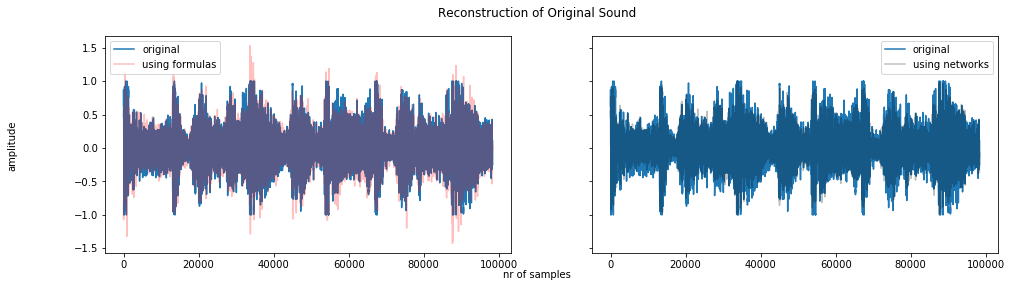

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True, sharex=True)
axs[0].plot(wav_sample)
axs[0].plot(wav_sample_h, alpha=0.25, c='red')
axs[0].legend(['original', 'using formulas'])

axs[1].plot(wav_sample)
axs[1].plot(wav_generated, alpha=0.25, c='black')
axs[1].legend(['original', 'using networks'])

fig.suptitle('Reconstruction of Original Sound')

fig.text(0.5, 0.04, 'nr of samples', ha='center')
fig.text(0.04, 0.5, 'amplitude', va='center', rotation='vertical')